<a href="https://colab.research.google.com/github/aleguma/tf-cert/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### A brief about Transfer Learning

Elements for Transfer Learning:

* A model that learned patterns/weights from a similar problem space
* The learned patterns get used/tuned to a specific problem
* Typical use case: Computer Vision, Natural Language Processing

Why use it?

* Can leverage an existin neural network architecture **proven to work** on problems similar to our own
* Can leverage a working network architecture which has **already learned patterns** on similar data to our own (often results in great results with less data), performing better than from scratch


## What we are going to cover (broadly)

* Downloading and preparing 10% of all Food101 classes (7500+ training images)
* Training a **transfer learning feature extraction** model
* Fine-tuning our feature extraction model (Food Vision mini) to **beat the original Food101 paper with only 10% of the data**
* Evaluating Food Vision mini's predictions
  * Finding the most wrong predictions (on the test dataset)
* Making **predictions with Food Vision mini on our own custom images**

Remember, machine learning practictioner motto -> *Experiment, experiment, experiment*.
  * Start small such as (*small dataset, small model*) and increase data (*larger dataset, small model*) and complexity (*larger dataset, larger model*), continuosly (*xtra-large dataset, xtra-large model*) and finishing with everything you got. 

## Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We have seen the power of transfer learning feature extraction and fine-tuning. Now it is time to scale up to all of the classses in Foo101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training data (leveraging the power of Deep Learning). 

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf
  * Random Forest
  * 101 food categories
  * 101000 images
  * 50.76% accuracy

So, our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Thu Oct  6 07:19:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we have created a series of helper functions to do different tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-10-06 07:19:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-06 07:19:15 (111 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we are downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook, so we can use it properly with TF dataset functions.

See here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [4]:
# Download the dataset, unzip it and establish path variables
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-10-06 07:19:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  64.8MB/s    in 23s     

2022-10-06 07:19:42 (67.3 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_calamari'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/eggs_benedict'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_and_sour_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/deviled_eggs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/seaweed_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 director

In [6]:
# 2 main directories: train/test
# 101 directories per train/test, which correspond each one to a class
# 75 images per class in training data set, 250 per class in the test folders

We are going to omit this step, but an important step is to visualize the data before starting to work with it, so you are familiar with it. Selecting some images at random and visualize them can give us a good sense of the data and also spot if there are some mistakes ("visualize, visualize, visualize" motto).

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",  #multiclass setting
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)  # do not shuffle test data for prediction analysis (we will see later why and how we will use this, otherwise this must be kept to False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a *big dog* model with transfer learning on 10% of 101 food classes

Here are the steps we are going to tasks

* Create a ModelCheckpoint callback (save model training at intervals)
* Create a data augmentation layer to build data augmentation right into the model (it might work better now as we have more classes/data, it is another experiment to try). Integrating data augmentation into the model has the benefit of data augmentation happening on the GPU instead of the CPU.
* Build a headless (no top layers) Functional EfficientNetB0 backbone model (we will create our own output layer)
* Compile the model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [8]:
# Create checkpoint callback (we could create and functionalize this in our helper_functions.py)
# If you use functions repeteadly, it is a good idea to put them in a library for later reuse and avoid repetitive typing
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",  # default is val_loss, which is also good, we change it just to try the parameters
                                                         save_best_only=True)  # so it will only save the model weights that achieved the best performance metric monitored (in this case validation accuracy)
# Remember: loss = lower value is better / accuracy metric = higher value is better                                                      

In [9]:
# Create data augmentation layer to incorporate it right into the model (so we get GPU acceleration for it)
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing  # in the future, these layers might change from the experimental module to the consolidated one (layers). They are kept in experimental while they are being tested!
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([     # we are goping to use some parameters to try, but it worth to experiment if they work with your data, and remove those ones that actually do not provide any benefit! (e.g., random flip might not work well)
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1/255.)   # rescale inputs of images between 0 and 1. This layer is only required if the model has no scaling built into it such as ResNet50 (the one we are going to use has it).
], name="data_augmentation")

In [10]:
# Setup the base model (feature extraction) and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)  # backbone = base_model, we will change the output layer to have 101 units, the same as # of classes we have
base_model.trainable = False # freeze all the weights/patterns that the base_model has learned on previous dataset

# Setup model architecture with trainable top layers
# In functional API, if the input is to a model, it goes into brackets in the model call; otherwise, if it is just a layer, it goes outside the brackets, on the right hand side (check below)
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")  # input layer
x = data_augmentation(inputs)  # data augmentation, augment images (only happens during traning phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen -> this will output a large tensor of varied shape
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)  # pooling the large output tensor from the model to a feature vector
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)  # custom top layer -> as it is a layer, takes it on the right hand side, as said above

model = tf.keras.Model(inputs, outputs)  # creating the model (ML algorithm) by giving inputs and outputs

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
# tf.keras.applications provides a lot of pretrained models -> https://www.tensorflow.org/api_docs/python/tf/keras/applications
# For some of them you will need to scale the inputs, but some of them has scaling already built in!

In [12]:
# Get a summary of the model we have created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [13]:
# Largest model so far! 
# Input layer -> data augmentation -> EfficientNetB0 backbone -> GlobalAvgPooling -> Output
# Only the parameters in the output layer are trainable, the backbone has its weights frozen

In [14]:
# We have just built a TRANSFER LEARNING FEATURE EXTRACTION model

In [15]:
# Let's compile the model
model.compile(loss="categorical_crossentropy",   # multiclass data
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])   # we are trying to beat the original paper's accuracy


# Fit the model for 5 epochs
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,  # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),   # validate on only 15% of test data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 96s 331ms/step - loss: 3.4669 - accuracy: 0.2458 - val_loss: 2.6855 - val_accuracy: 0.3848
Epoch 2/5
237/237 [==============================] - 62s 256ms/step - loss: 2.3515 - accuracy: 0.4564 - val_loss: 2.2584 - val_accuracy: 0.4494
Epoch 3/5
237/237 [==============================] - 61s 253ms/step - loss: 1.9769 - accuracy: 0.5296 - val_loss: 2.0960 - val_accuracy: 0.4748
Epoch 4/5
237/237 [==============================] - 51s 213ms/step - loss: 1.7573 - accuracy: 0.5754 - val_loss: 2.0186 - val_accuracy: 0.4865
Epoch 5/5
237/237 [==============================] - 48s 201ms/step - loss: 1.6096 - accuracy: 0.6042 - val_loss: 1.9480 - val_accuracy: 0.5005


In [16]:
# Model training takes more time now as we have more data, so more patterns to discover!!
# Val_accuracy around 50%, might seem bad, but it is actually quite good as this is 101 classes!! So random guessing is lower than 1%!
# Anyway this val_accuracy is not 100% correct, as we only validated in 15% of the data during training

In [17]:
# Let's evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 59s 74ms/step - loss: 1.7136 - accuracy: 0.5515


[1.7135694026947021, 0.5514851212501526]

In [18]:
# Wow! So we have just beat a paper, that had 50.76% accuracy on 101 different classes, with just 10% of the training data and in less than 5 mins!
# Awesome! That demonstrates the power of deep learning, and more specifically, the power of transfer learning!
# In a few lines of code and 5 mins we beated a paper in the first try!

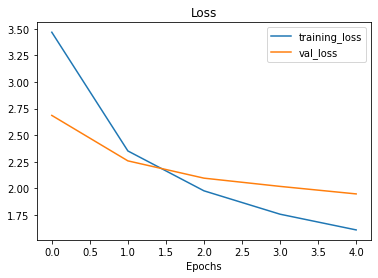

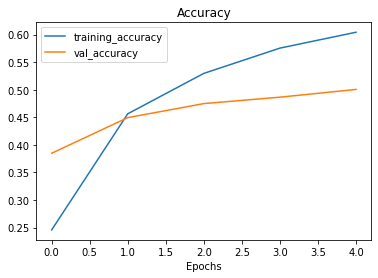

In [19]:
# Let's check the loss curves
plot_loss_curves(history_all_classes_10_percent)

In [20]:
# Quite good looking curves, but the separation of the curves at the end (which should be very similar to each other, like dance partners, dancing side by side) evidences/hints OVERFITTING on the training set!

In [21]:
# Validation loss increasing while validation loss is decreasing hints OVERFITTING
# Means that our model is idenfitying patterns in the training data too well and it is not generalizing well to unseen data
# The model is performing too well on the training data and not generalizing to unseen data
# How can you reduce overfitting? 
# Apply something! But we are not going to deal with it now, let's continue with fine-tuning our model and see if that improves it...

## Fine-tuning

Now we were only training the top layer, let's see if things improve training other underlying layers...

In [22]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5, so we are only going to train the last 5
# Top layers learn more fine-grained features than bottom layers, so that is why the latter are always unfrozen the last
# In this case we are going to just unfreeze 5 of the top layers, to slowly adjust those patterns in the last layers to, hopefully, improve the model performance on our own custom data set
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [23]:
# When we do some modifications on the model, recompile...and also for fine-tuning, we adjust (lower) the learning rate! (rule of thumb is 10x)
# Recompile model with lower learning rate (it is typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # default is 0.001, now is lowered by 10x
              metrics=["accuracy"])

In [24]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [25]:
# The first two do not have anything trainable. The EfficientNetB0 has something trainable (last 5 layers), but the output says true if just one is trainable
# Global average pooling is not something anyway trainable, but the default value is true. This pooling layer just squeezes a high dimensional tensor into a feature vector
# The output layer, our dense layer, has actually trainable parameters

In [26]:
# Let's explore what layers are trainable in the backbone model (EfficientNetB0)
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(base_model.layers):   # could be also indexed as model.layers[2] == base_model
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [27]:
# Nice! As we can see, the last 5 layers are trainable! But every other layer is not trainable!

**Note**: If you have a really massive dataset, you can fine-tune many more layers or every layer. But, typically, you will start to slowly fine-tuning, layer by layer.

In general, the more layers you unfreeze, the lower the learning rate you use!

In [28]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10   # model has already done 5 epochs (feature extraction), this is the total number of epochs we are after (5 + 5 = 10 epochs)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15 * len(test_data)),  # otherwise training will take too long
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])   # starting training on the last epoch of our feature extraction model, where we left off


Epoch 5/10
237/237 [==============================] - 55s 201ms/step - loss: 1.3614 - accuracy: 0.6492 - val_loss: 1.9268 - val_accuracy: 0.5061
Epoch 6/10
237/237 [==============================] - 46s 192ms/step - loss: 1.2349 - accuracy: 0.6706 - val_loss: 1.9215 - val_accuracy: 0.5072
Epoch 7/10
237/237 [==============================] - 44s 184ms/step - loss: 1.1496 - accuracy: 0.6904 - val_loss: 1.8691 - val_accuracy: 0.5175
Epoch 8/10
237/237 [==============================] - 43s 178ms/step - loss: 1.0747 - accuracy: 0.7171 - val_loss: 1.8581 - val_accuracy: 0.5196
Epoch 9/10
237/237 [==============================] - 40s 168ms/step - loss: 1.0284 - accuracy: 0.7296 - val_loss: 1.8934 - val_accuracy: 0.5117
Epoch 10/10
237/237 [==============================] - 42s 173ms/step - loss: 0.9661 - accuracy: 0.7391 - val_loss: 1.8485 - val_accuracy: 0.5222


In [29]:
# Does not seem the model improved much, but that output shows only on 15%
# 
# Let's evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 68s 86ms/step - loss: 1.6102 - accuracy: 0.5748


[1.6102244853973389, 0.5748118758201599]

In [30]:
# So as we can see, we had just a slight boost, it did not work too well (improvement of 2%)
# It is important to note that fine tuning will not necessarily always improve your results
# If that happens, did is why we used a checkpoint, just revert to it and use the feature extraction model instead (if fine tuning performs terribly)
# That is why you have to "experiment, experiment, experiment"; you do not know what is going to work ahead of time

In [31]:
# Maybe if we just keep the feature extraction for 5 epoch is better than fine-tuning; that is another experiment worth to try
# But let's compare properly both models

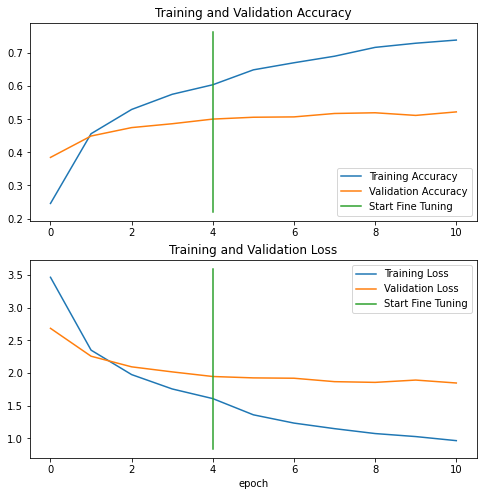

In [32]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [33]:
# It seems that with fine-tuning we get some significant gains on the training accuracy, but not for the validation, which kind of plateaus and does not change much
# The same is observed for the loss; the training loss goes down during fine-tuning, but not the validation loss which seems to hit a plateau
# So this significant separation of the curves tells us that the model is OVERFITTING ON THE TRAINING DATA

In [34]:
# So to improve this, to get this curves closer together, you will have to look into some methods to prevent overfitting (explained in previous modules)
# We can perform several experiments to try to improve the model but...
# We are going to deal now with how to save, load, predict on custom data and also find out which predictions are most wrong our test data!

## Saving and loading our model

To use our model in an external application, we will need to save it and export it somewhere.

In [35]:
# Save our fine-tuning model
model.save("drive/MyDrive/tf_course/101_food_classes_10_percent_saved_big_dog_model")   # There are several options but here we will try to mount Google Drive and save it there

In [36]:
# Load and evaluate the saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tf_course/101_food_classes_10_percent_saved_big_dog_model")

**Note**: Loading the model may output a large amount of warnings, there is a thread tracking this issue on GitHub: https://github.com/tensorflow/tensorflow/issues/40166. However, it seems according to the TensorFlow documentation that loading warnings can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_usage

In [37]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 68s 83ms/step - loss: 1.6102 - accuracy: 0.5748


[1.6102244853973389, 0.5748118758201599]

In [38]:
# The results from our loaded model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.6102244853973389, 0.5748118758201599]

In [39]:
# Cool, the loaded model provides the exact same results than the original model, so it is the same, all good!

# This is just a step to verify that the loaded model is the same as the original model!

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [40]:
import tensorflow as tf

# Download pretrained model (one that was prepapred earlier, so all predictions are similar) As DL is probabilistic, if we do not set the seed, every time would lead to slightly different results!
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-10-06 07:37:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  31.0MB/s    in 1.4s    

2022-10-06 07:37:53 (31.0 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [41]:
# Unzip it
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [42]:
# Let's load in the model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [43]:
# You can ignore this warnings as the TF documentation says

In [44]:
# Evaluate loaded model (the one we just downloaded on test data), so we verify it is working
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 68s 83ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

In [45]:
# Good! The model works well and it is a slightly better model than the one we built before (some small % better)

## Making predictions with our trained model

In [46]:
# Make predictions with model - the model outputs a prediction probability tensor/array as we are in multiclass setting and use softmax activation function, then we can take those numbers and figure out what class the model thinks is the most likely 
pred_probs = model.predict(test_data, verbose=1)   # IMPORTANT: the data you pass to test a model has to be in the same format as the one the model was trained on (e.g., if the model was trained with 224, 224, 3 images, it expects the same or it will fail)

790/790 [==============================] - 80s 100ms/step


In [47]:
# What is the size of the test_data
len(test_data)

790

In [48]:
# But this refers to batches, the total amount of images is...
len(test_data) * 32

25280

In [49]:
# In reality, we have 25250 but the last batch is just rounded up in our calculation, that is composed of only 2 samples and not 32

In [50]:
# So based on this, how many predictions are there?
len(pred_probs)

25250

In [51]:
# There is exactly one prediction for every test image

In [52]:
# So, as there are 101 classes, how many values come along with every prediction?

In [53]:
# What is the shape of our predictions?
pred_probs.shape

(25250, 101)

In [54]:
# Yes, exactly 101 values; that is, a value per class, with very small values and some larger ones; output of the softmax function

In [55]:
# Let's see what the first 10 predictions look like
pred_probs[:10]

array([[5.9541997e-02, 3.5742044e-06, 4.1377008e-02, ..., 1.4138679e-09,
        8.3530824e-05, 3.0897509e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780820e-04, ..., 5.4287048e-05,
        7.8362204e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533648e-05, 1.4866963e-03, ..., 7.1891270e-07,
        5.4397265e-07, 4.0275925e-05],
       ...,
       [4.7313246e-01, 1.2931228e-07, 1.4805609e-03, ..., 5.9750048e-04,
        6.6969005e-05, 2.3469245e-05],
       [4.4571832e-02, 4.7265476e-07, 1.2258517e-01, ..., 6.3498501e-06,
        7.5318512e-06, 3.6778776e-03],
       [7.2438955e-01, 1.9249771e-09, 5.2310937e-05, ..., 1.2291373e-03,
        1.5792714e-09, 9.6395648e-05]], dtype=float32)

In [56]:
# What does the first prediction probability array look like?
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([5.9541997e-02, 3.5742044e-06, 4.1377008e-02, 1.0660534e-09,
        8.1614111e-09, 8.6639478e-09, 8.0927191e-07, 8.5652403e-07,
        1.9859070e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532185e-04, 7.8049184e-10, 7.4230076e-04, 3.8916409e-05,
        6.4740357e-06, 2.4977301e-06, 3.7891128e-05, 2.0678326e-07,
        1.5538435e-05, 8.1507017e-07, 2.6230514e-06, 2.0010684e-07,
        8.3827518e-07, 5.4216030e-06, 3.7390816e-06, 1.3150530e-08,
        2.7761480e-03, 2.8051860e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688880e-04, 7.6406842e-10, 4.0452872e-04, 1.3150632e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062943e-02, 8.2466846e-07,
        8.5365838e-07, 1.7138658e-06, 7.0525025e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681568e-06, 1.8525114e-07,
        3.3619767e-08, 3.1522580e-04, 1.0410922e-05, 8.5448272e-07,
        8.4741855e-01, 1.0555444e-05, 4.4094620e-07, 3.7404177e-05,
        3.5306122e-05, 3.2489035e-05, 6.7314730e

In [57]:
# So, as expected, a lot of tiny values and some larger ones. The most likely class is the largest value, but the model has given a probability to each single class.
# They all some up to 1 (as this is what softmax does), the larger class seems to have 8.4741855e-01 prob (84%), so the classifier is quite sure about it!

Our model outputs a **prediction probability array** (with *N* number of variables, where *N* is the number of classes) for each sample passed to the predict method.

In [58]:
# We get one prediction probability per class (in our case, there is 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicte probability by the model for sample 0: {pred_probs[0].argmax()}")  # we could use also tf.argmax(pred_probs[0])

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9541997e-02 3.5742044e-06 4.1377008e-02 1.0660534e-09 8.1614111e-09
 8.6639478e-09 8.0927191e-07 8.5652403e-07 1.9859070e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532185e-04 7.8049184e-10 7.4230076e-04
 3.8916409e-05 6.4740357e-06 2.4977301e-06 3.7891128e-05 2.0678326e-07
 1.5538435e-05 8.1507017e-07 2.6230514e-06 2.0010684e-07 8.3827518e-07
 5.4216030e-06 3.7390816e-06 1.3150530e-08 2.7761480e-03 2.8051860e-05
 6.8562017e-10 2.5574853e-05 1.6688880e-04 7.6406842e-10 4.0452872e-04
 1.3150632e-08 1.7957391e-06 1.4448174e-06 2.3062943e-02 8.2466846e-07
 8.5365838e-07 1.7138658e-06 7.0525025e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681568e-06 1.8525114e-07 3.3619767e-08 3.1522580e-04
 1.0410922e-05 8.5448272e-07 8.4741855e-01 1.0555444e-05 4.4094620e-07
 3.7404177e-05 3.5306122e-05 3.2489035e-05 6.7314730e-05 1.2852565e-08
 2.6219704e-10 1.0318108e-05 8.5744112e-05 1.

In [59]:
# How do we get the class name?
test_data.class_names[52]   # if we select the 52, we will know which actual class corresponds to position 52

'gyoza'

In [60]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)  # get the maximum index value across all samples

In [61]:
# How do they look?
pred_classes   # now just the maximum index value is retrieved for each sample

array([ 52,   0,   0, ..., 100,  94, 100])

In [62]:
# How many pred classes do we have?
len(pred_classes)

25250

In [63]:
# So now we have a predicted class index for every image in our test data set

Now we have got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

Now the `test_data` is wrapped up in a TF `BatchDataset`, so we have to unbatch the data set and pull out the labels and get them in a format that is as we have our current predictions. So we can compare *apples to apples* if the tensors are in the right format and shape. As if we try to compare an array with the `BatchDataset` directly, this will output error.

In [64]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [65]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():   # this TF method will unbatch the test_data of the 790 batches into a list of individual samples
  y_labels.append(labels.numpy().argmax())   # currently the test labels in the ground_truth are one hot encoded labels (so all zeroes except for a 1, e.g., [0, 0, 0, 1, 0, 0...]) we want to retrieve the index value where the "1" occurs, so we use argmax()
                                             # we apply numpy so it returns the test labels coded in a numpy array, and then we use the argmax()
y_labels[:10]   # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [66]:
# How many y_labels are there?
len(y_labels)

25250

In [67]:
# Why are the first 10 all zeroes? Is this not working?
# It is, it is all zeroes as when we originally loaded the data, we put Shuffle=False, so the images were not randomly shuffled, and they were taken in order, so all the first images have label 0!
# Shuffle=False is needed to make evaluation on our test data, otherwise every time the data is loaded the order will be shuffled, and provide different results when we unravel it
# So Shuffle=False takes the order as it is provided (e.g., apple_pie first, then baby_back_ribs, etc.) and not randomly!
# So now we have all in the same order, so we can compare the predictions and ground_truth data correctly!!

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score. There are some other ways.


In [68]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [69]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)  # This could only work if they are in a comparable format

sklearn_accuracy

0.6077623762376237

In [70]:
# Nice! So basically the same number as we got before (results_downloaded_model)
# So this means they are in the same order after the unbatching! Cool!
# The trailing numbers difference is, again, a matter of decimal number precision storage

In [71]:
# Does this metric come close to our model's evaluate results?
import numpy as np

np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

In [72]:
# True, so cool, the differences here are not important, just on the way the numbers are stored!
# So confirmed, the order of y_labels is in the same order as the model's predictions output
# Then we can proceed comparing them, as we are sure we are comparing the labels for each sample correctly!

## Let's get visual: making a confusion matrix

In [73]:
from helper_functions import make_confusion_matrix

In [74]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

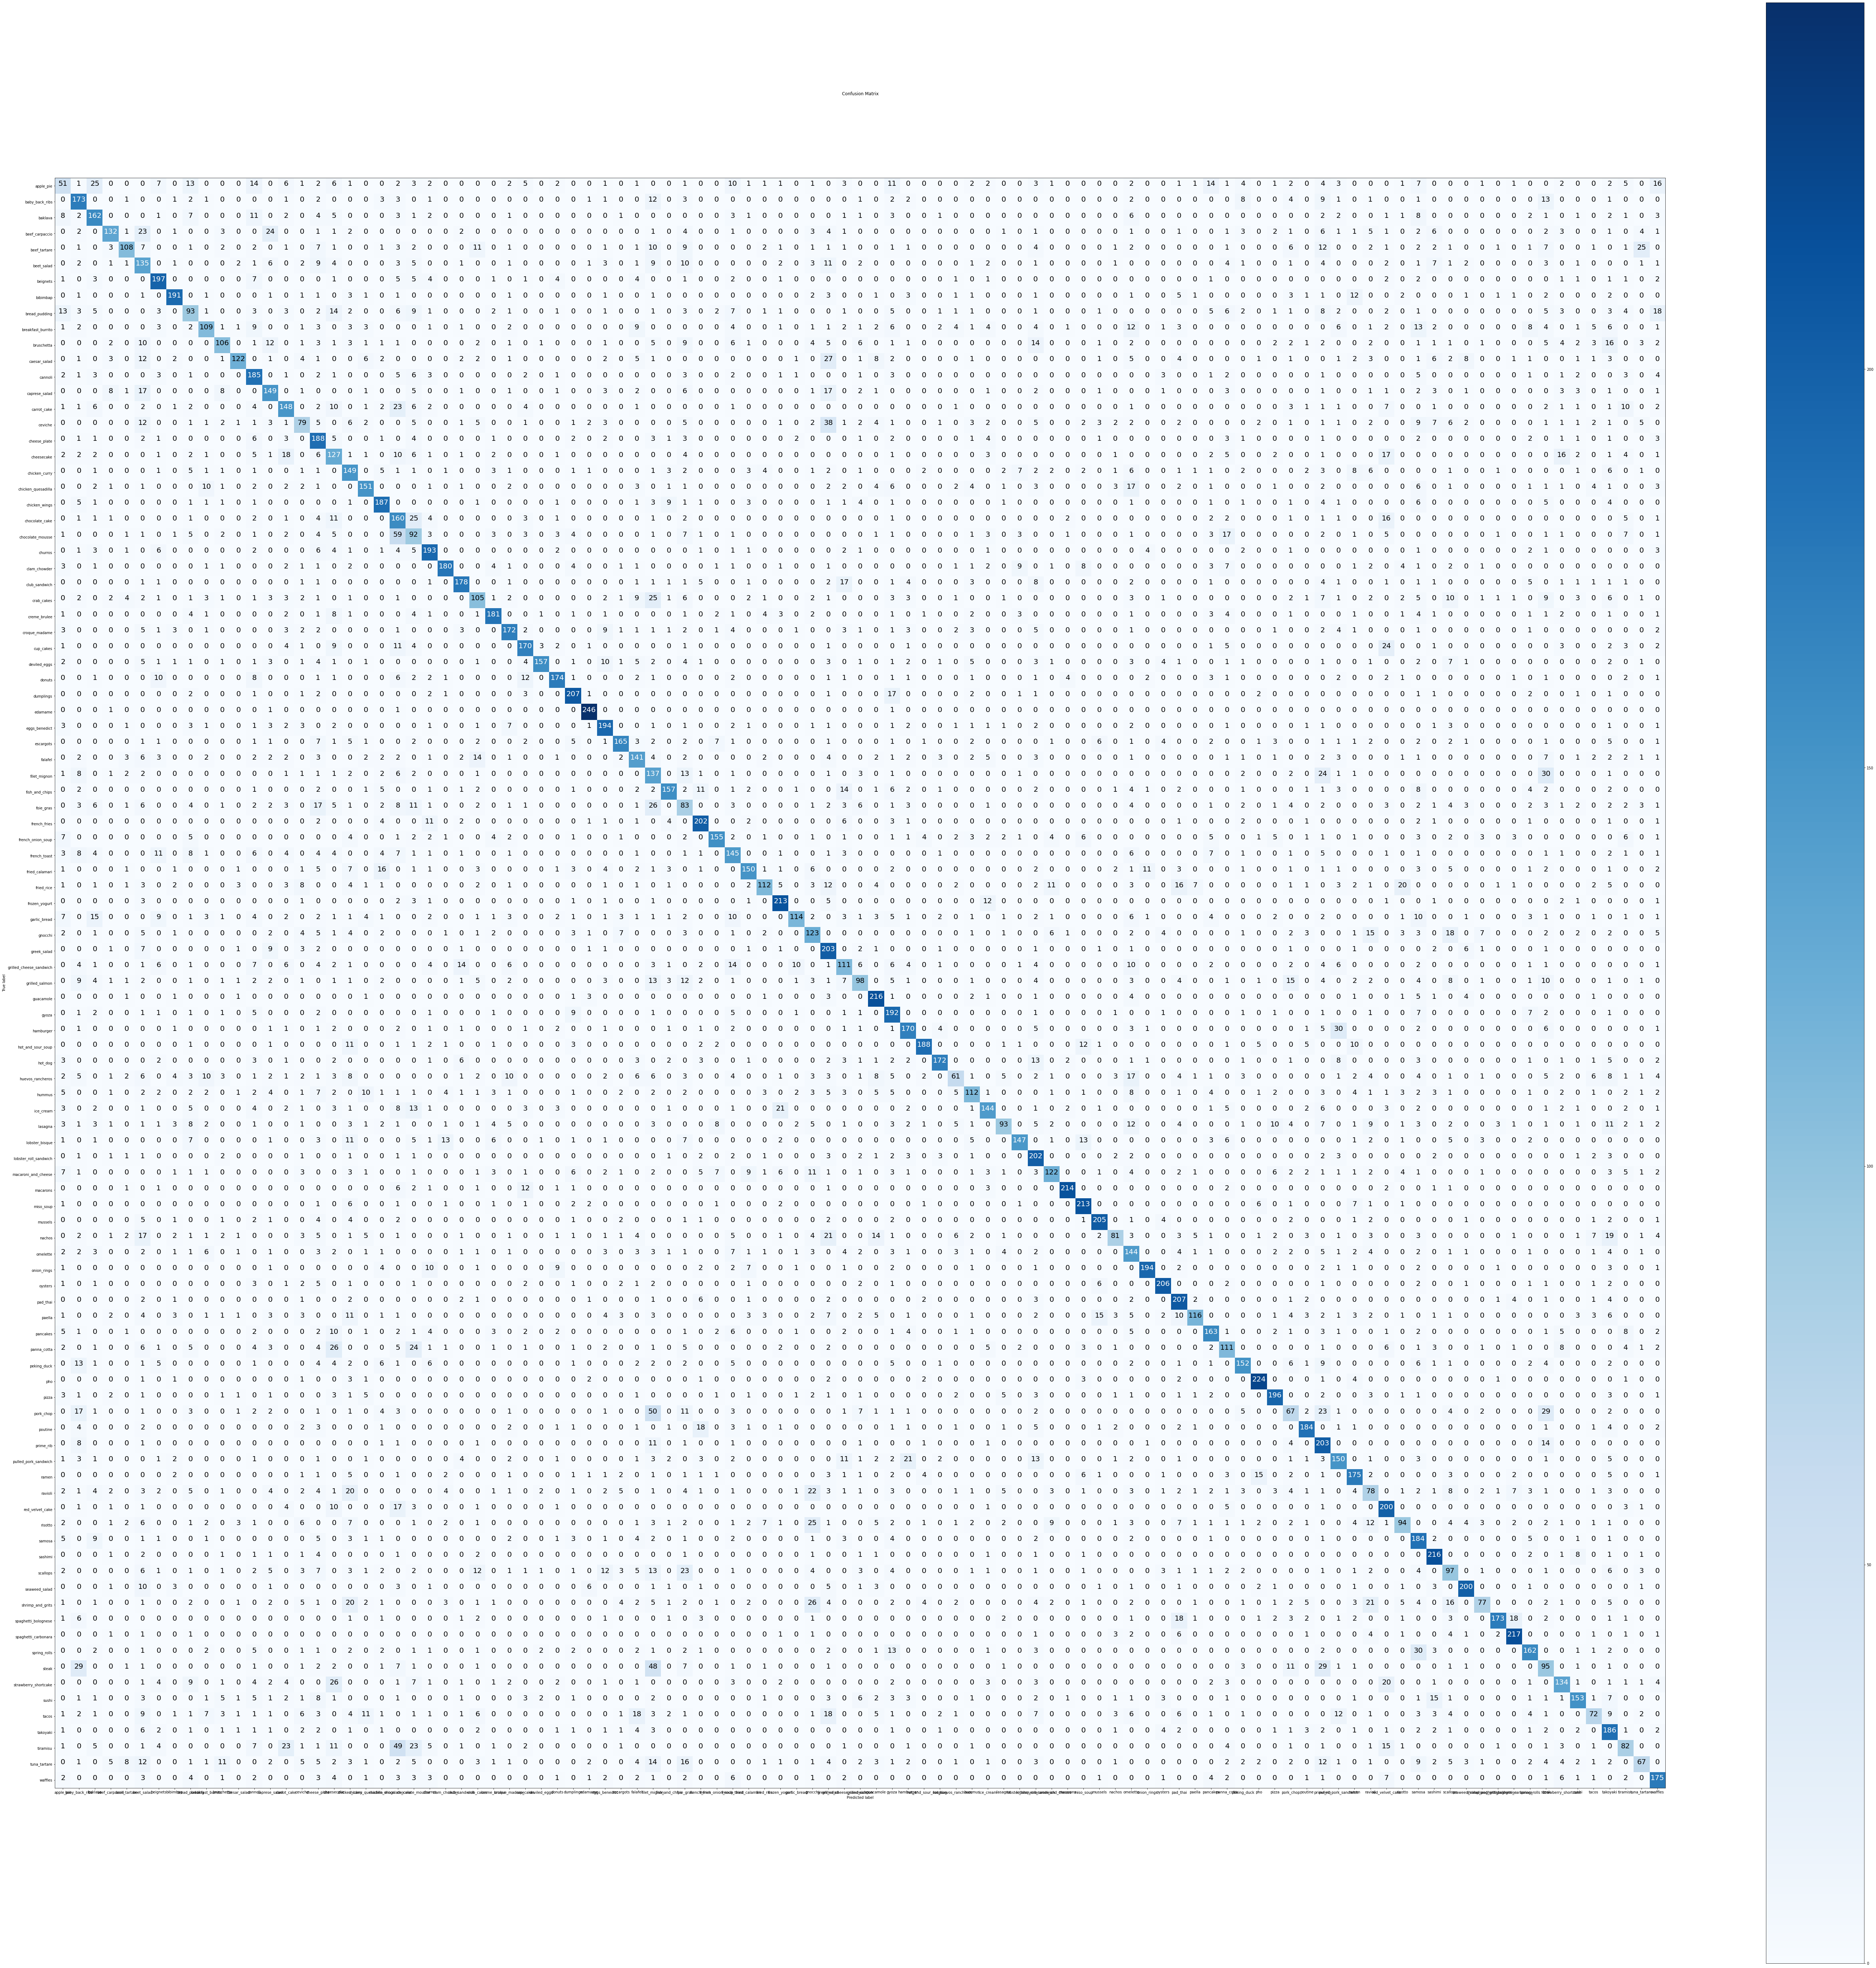

In [75]:
make_confusion_matrix(y_true=y_labels,   # from the helper_function script
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20)   

In [76]:
# We need to make some changes to our make_confusion_matrix function to ensure the X-lables print vertically
# Let's paste the code below and modify it (extracted from helper_function.py)

In [77]:
# Dependencies for the make_confusion_matrix function
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

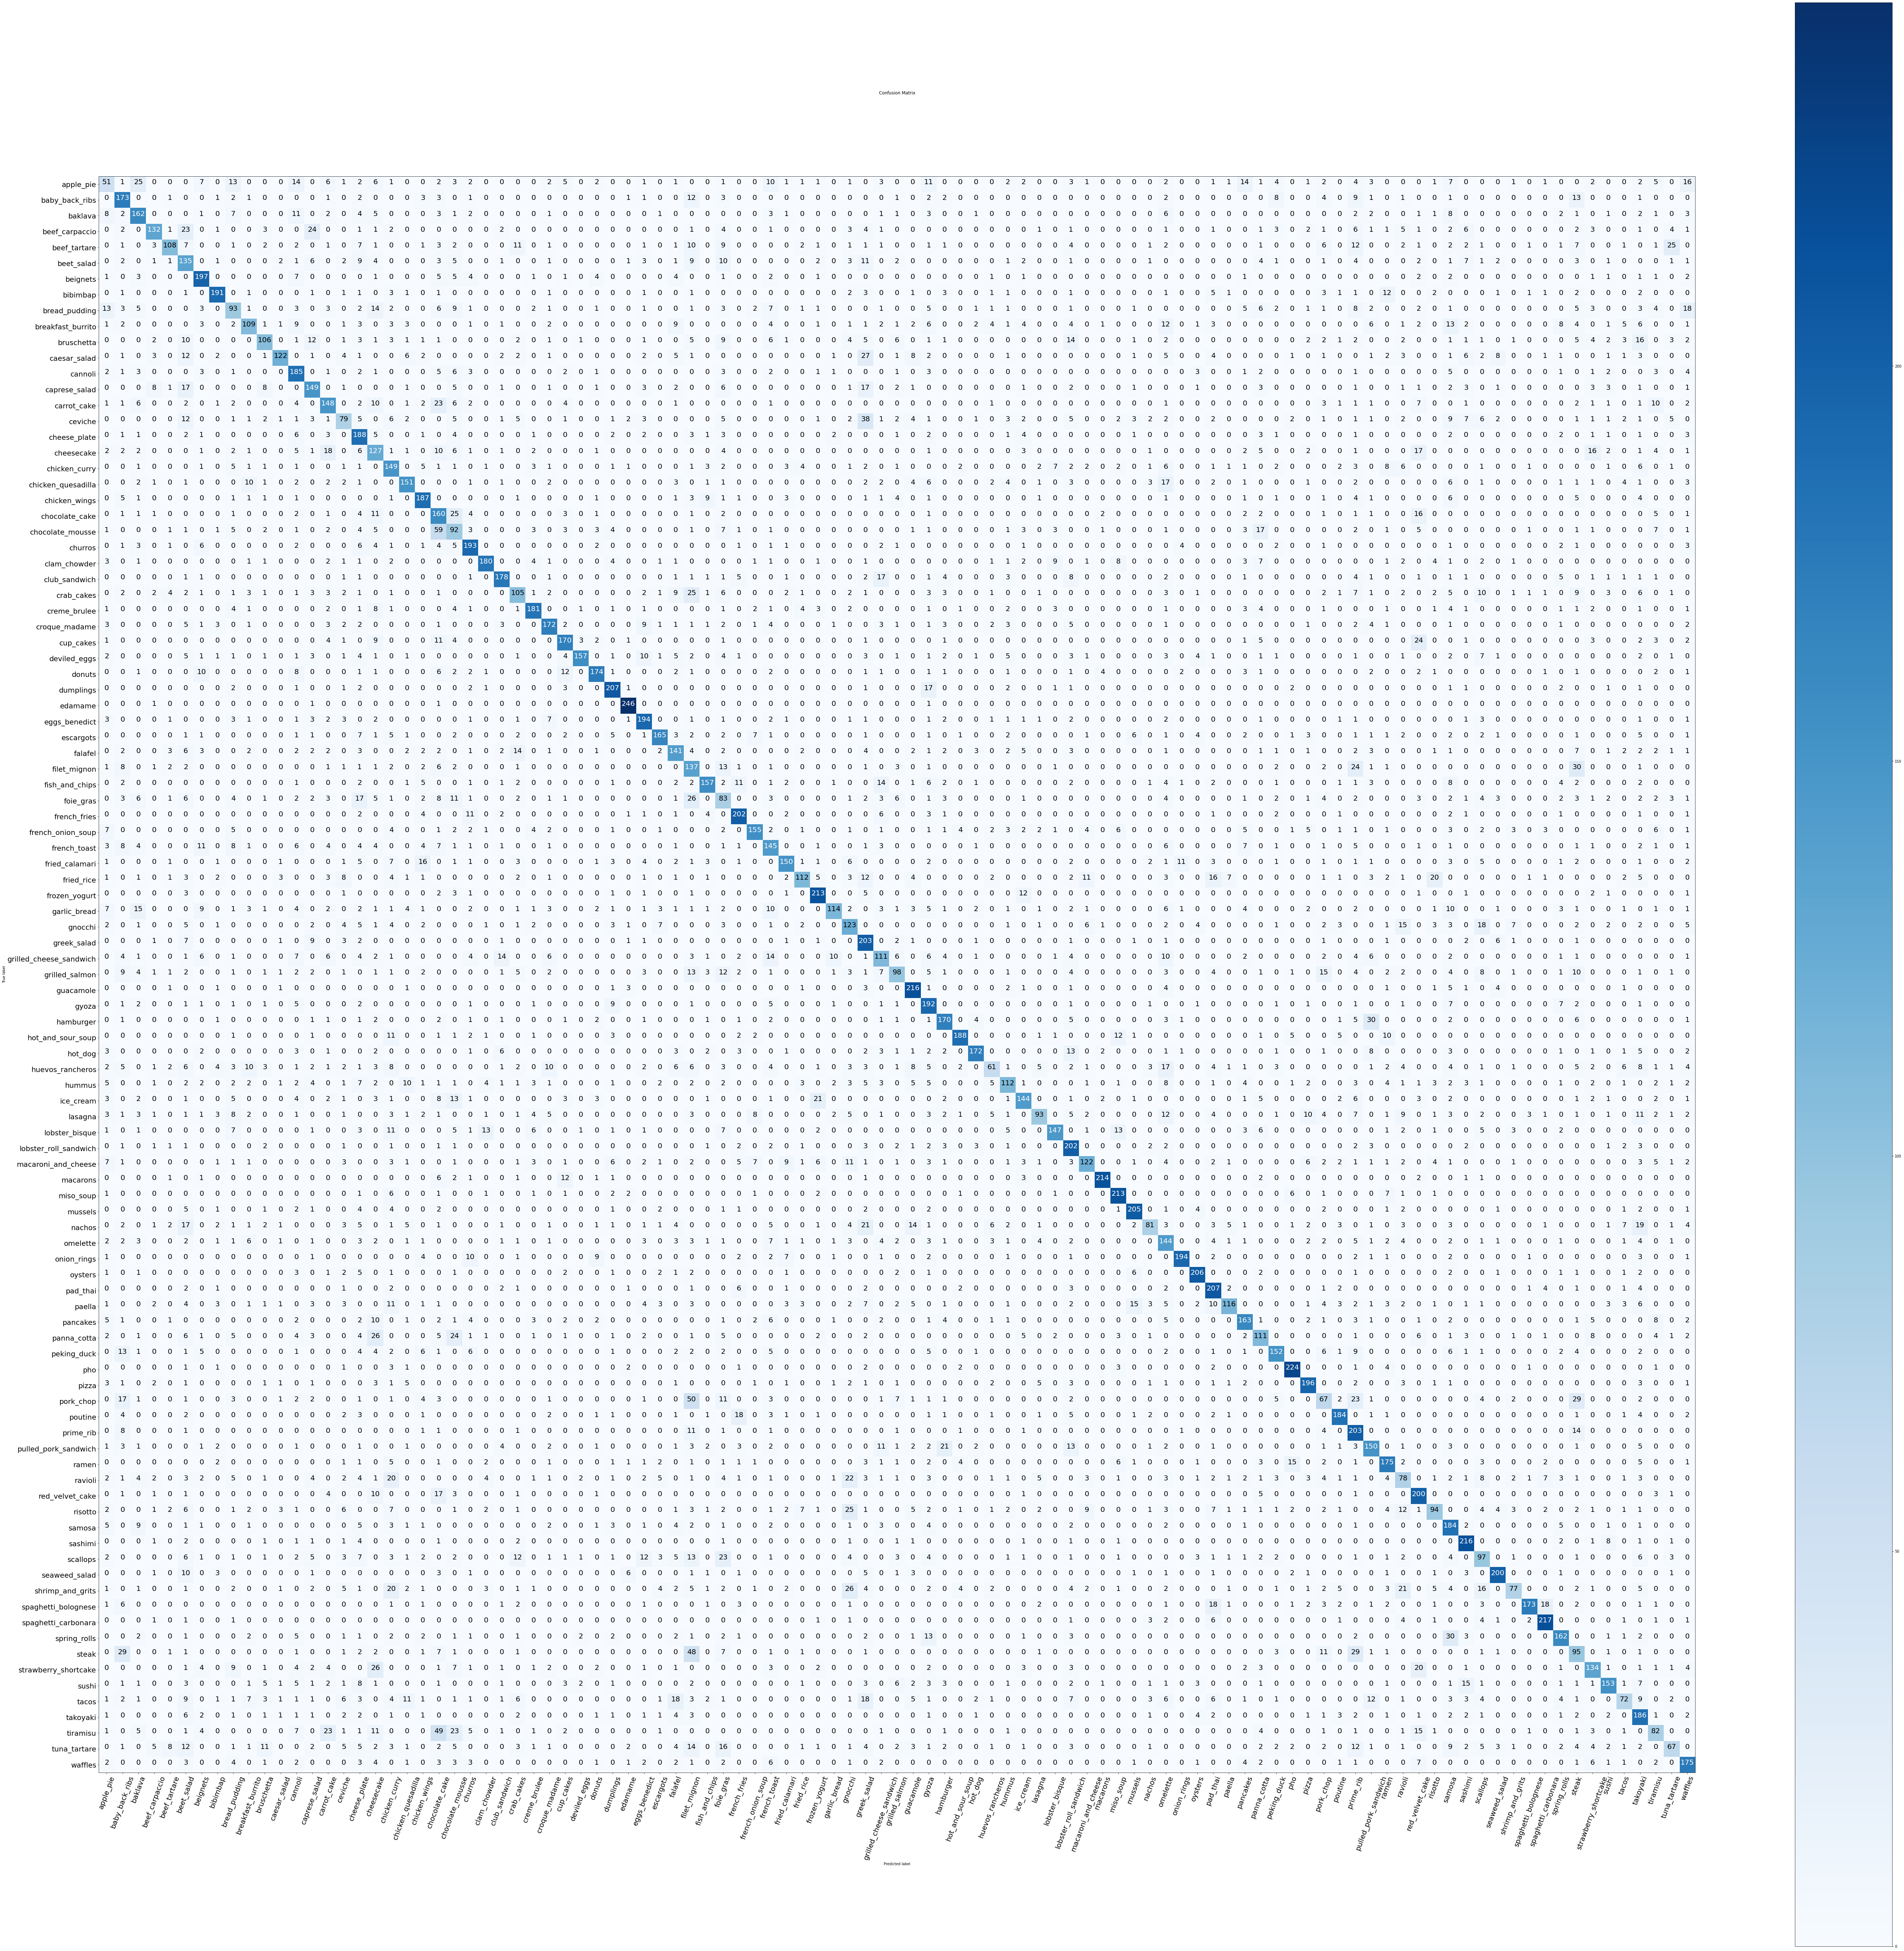

In [78]:
make_confusion_matrix(y_true=y_labels,   # from the helper_function script
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

In [79]:
# Awesome! Now it reads much better!!
# The x-axis has the predicted label, and the y-axis the true label
# The darker the square outside the main diagonal, more predictions were wrong
# The model is confused about some kind of normal cases: e.g., tiramisu for chocolate cake and pork-chop with steak

## Let's keep the evaluation train going, time for a classification report

*Scikit-learn* has a helpful function for acquiring many different classification metrics per class (e.g., **precision, recall and F1**) called **classification report**, let's try it out.

Documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

Remember that...

**Classification evaluation methods**

* **Accuracy**: default metric for classification problems. Not the best for imbalanced classes.
* **Precision**: higher precision leads to less false positives.
* **Recall**: higher recall leads to less false negatives.
* **F1-score**: combination of precision and recall, usually good overall metric for a classification model (especially when there is a large amount of classes).
* **Confusion matrix**: when comparing predictions to truth labels to see where model gets confused. Can be hard to use with large number of classes.

In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [81]:
# This is giving results class by class, not the overall value. So this hints us what classes is the model misclassifying the most and the best and a good relevant analysis of the model's performance across classes.
# A well recognized class should have high precision and recall, and, consequently, the lower, the worse.
# It also gives us some accuracy metrics, very relevant...
# F1 is a good overall measure of precision and recall so for multi-class setting...

In [82]:
# How about creating a plot of the F1-score of all the different classes so we can see a class by class breakdown of how our model is performing

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they are quite hard to understand.

How about we create a visualization to get a better understanding?

In [83]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels,
                                                   pred_classes,
                                                   output_dict=True)

classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [84]:
# Class number is the key, and the performance metrics are the values for each class and support (i.e., how many classes there are)

Let's plot all of our classes F1-scores...

In [85]:
# Create empty dictionary
class_f1_scores = {}

# Loop through classification report dictionary items and create a dictionary with f1-scores and class names
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key, located in the last lines of the report
    break
  else:
    # Add class names and f-1 scores to the new (empty) dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [86]:
# We can see now easier what classes are well identified, and which are not performing well at all

# To improve readibility of the dictionary, how about sorting the values in descending order? From higher f1-score to lower.

In [87]:
# Turn f1-scores into dataframe for visualization - there are many ways to visualize, but I prefer it because pandas dataframes are visual
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)  # create DataFrame and sort it accorting to value in F1-score column

In [88]:
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

In [89]:
# Awesome! We can see the ordered list now, much better for understading!
# Let's put it in a visual way!

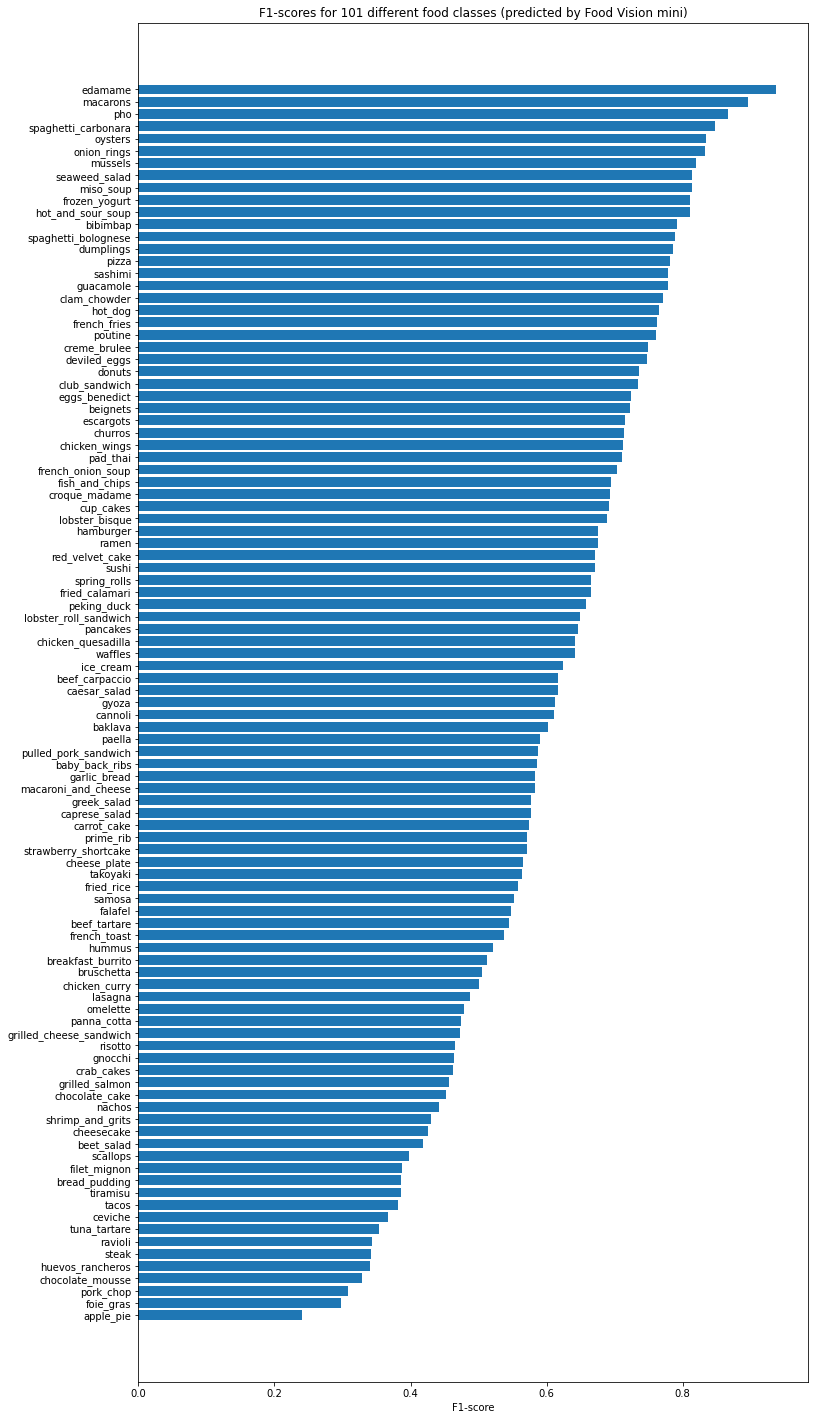

In [90]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)  # get f1-score values and put them in a horizontal bar chart
ax.set_yticks(range(len(f1_scores)))  # creating the spaces
ax.set_yticklabels(f1_scores["class_names"]) # filling the spaces with the labels
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 different food classes (predicted by Food Vision mini)")
ax.invert_yaxis();  # reverse the order of the plot (from higher value to lower, otherwise it plot it the other way around)



In [91]:
# This is a very good visualization for a presentations
# Edamame is crushing it, as well as macarons, very good F1 score! Are these classes much different to the others? That something we could check and visualize as well!
# We can easily see the model does very bad on apple_pie (especially) and some other categories
# We could create a threshold of F1 score for classes, and if they are not over that threshold then we could prevent those classes to reach the actual application until we can ensure a good F1 score value for them
# For example, a 0.5 F1 score threshold would make classes to be included or not; and for the classes that are not included, more photos would be needed (e.g., lasagna, panna_cotta, etc.)

In [92]:
# For a better visualization, it would be good to add the F1 score figure/value at the end of each rectangle/bar
# Challenge: add values to the end of each bar of what the actual F1 value is 
# (hint: use the "autolabel" function from https://matplotlib.org/2.0.2/examples/api/barchart_demo.html)

In [93]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        print(rect)
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

In [93]:
# All this evidences the power of visualization; numbers are good, but visualization shows things more clear
# But there is a lot more exploration and visualization that we could do, like seeing the categories that are more confused, the ones better discriminated vs. the others, etc.
# But this is a good way to starting to see see how we can get insights on a per class basis!

Exercise: Try visualizing some of the most poorly predicted classes (e.g., `apple_pie`, `pork_chop`), do you notice any trends among them? Why might our model be having trouble with them?

This is part of data exploration and also evaluating our model, that is, to visualize and explore the most poorly performing classes. This is what we are going to focus next...

In [94]:
# Up to now we visualized some metrics, now let's visualize some predictions!

## Visualizing predictions on test images

Now, this is the real test, how does our model go on food images not even in our test data set (images of our own, we will see this later on).

To visualize our model's predictions on our own images, we will need a function to load an preprocess images (as our model can only predict on the same format of tensors or same shape or same type of data that the model has been trained on), specifically it will need to:

* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has been trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary, that is, if the scaling layer is not included in the model architecture)

In [96]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):  # scale the pixel values by default
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified shape (img_shape, img_shape, color_channels = 3)
  
  Args:
    filename (string): path to target image
    img_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)   # the same format that our model was trained on
  """
  # Read in the image
  img = tf.io.read_file(filename)   # returns a Tensor of type string (basically a string), check documentation at https://www.tensorflow.org/api_docs/python/tf/io/read_file

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)  # we hardcode channels, so if a PNG file is read (which have 4 channels), it will force it and convert it to 3 channels, which is what our model expects!

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])   # keeping channels the same, new size, new width

  # Scale? Yes/No
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.  # the image is already in the form of a tensor, so we can return it directly scaling it, this just says, divide all values in img by 255.
  else:
    return img # we do not need to rescale images for EfficientNet models in TensorFlow

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

This is again, more data exploration into trying to know where our model is correct/wrong. We can look at all the metrics we want, but visualizing stuff makes usually better understanding of the situation.

Specifically, we will write some code to:
1. Load a few random images from the test dataset (could be a function selecting specific classes, but we are going to do it random this time)
2. Make predictions on the loaded images
3. Plot the original image/s along with the model's predictions, prediction probability and the truth label

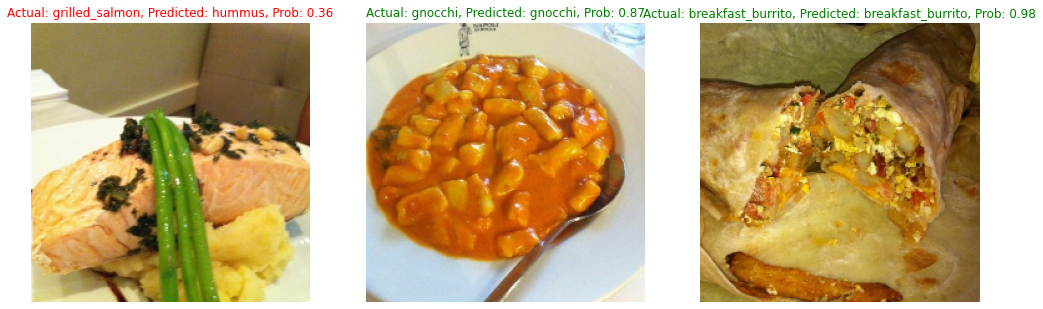

In [109]:
# We will randomly pick a class, randomly pick an image within that class and then make a prediction on that specific image, plot the image, plot the model's prediction as well as the truth label and the prediction probability

# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))   # we will plot a figure
for i in range(3):    # selecting three images to plot/predict
  # Choose a random images from random classes
  class_name = random.choice(class_names)  # selects a class randomly from class_names list
  filename = random.choice(os.listdir(test_dir + "/" + class_name))   # selects a random image from the randomly selected class
  filepath = test_dir + class_name + "/" + filename   # prints the filepath for the images

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)   # the function we created above, as our model has scale layer built-in, we turn off the scaling for these images! Otherwise we would need to keep it as True (default)
  img_expanded = tf.expand_dims(img, axis=0)   # as we trained our model on batches, it expects an additional batch size dimension not only the 3-D shape of the image. If we do not include this, it gives a shape error, very common in CV apps! This simply adds another dimension at the beginning, so it matches the expected shape by the model!! It doesnt change the values, but it changes the dimension of the tensor to the expected one (batch type, so 4 dimensions instead of 3)!
  pred_prob = model.predict(img_expanded)   # returns a 101 tensor of prediction probabilities (prediction probabilities array)
  pred_class = class_names[pred_prob.argmax()]   # getting the name (based on index) of the most likely class from the prediction probabilities tensor (get highest prediction probability index and the corresponding class name)

  # Plot the images
  plt.subplot(1, 3, i+1)   # 1 row, three columns, i+1 element of the iteration
  plt.imshow(img/255) 
  if class_name == pred_class: # if predicted class matches the truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name}, Predicted: {pred_class}, Prob: {pred_prob.max():.2f}", c=title_color)  # set the title with predicted label, probability and true label! The color changes if prediction is correct!
  plt.axis(False);


In [112]:
# Awesome!! 
# So you can go through these, visualize many of them and figure out what is right, what is wrong, etc.
# It is good to verify and see where the mistakes happen, as we can see the mistakes, if they happen on specific images, if they would also be mistaken maybe by humans, etc.
# So we can understand why the model got confused (maybe the images are really confusing, not clear, very hard to predict on even for a human etc.)

In [115]:
# After checking many random instances using the previous function, another thing we might want to do is to FIND THE MOST WRONG PREDICTIONS
# Meaning those images where the prediction is wrong and the model is really sure about it (the model has a very high prediction probability output for that class)
# So the model is very confident on its prediction, but is wrong for some reason

## Finding the most wrong predictions

* A good way to inspect your model's performance is to **view the *wrong* predictions with the highest prediction probability (or highest loss)**

* Can reveal insights such as:

  * Data issues (wrong labels, e.g., model is right, label is wrong)
    * In that case, we should use kind of an active learning approach (involving a human in the loop) to improve the data set and relabel the wrong image.
  * Confusing classes (get better/more diverse data)
    * Get some better or more diverse data or even merge some confusing classes that might be too similar or really similar. It will all depend on what type of problem you are trying to solve.

**How are we going to do that?**

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using [list_files()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method (from tensorflow library).
2. Create a Pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names and ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label does not match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top)
5. Visualize the images with the highest prediction probability but have the wrong prediction.


In [118]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", # the stars because we want all the jpg files within all the classes folders
                                      shuffle=False):   # as we did not shuffled it before when we created the test_data, so we also do not want it now to import the file names shuffled either!    
  filepaths.append(filepath.numpy())  # we have to convert it to numpy format, otherwise is in Tensor string format!

filepaths[:10]  # cool, it works!

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [119]:
# It is keeping the order, as that is how we did the predictions before, in order, without shuffling!

In [123]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd

pred_df = pd.DataFrame({    # we are going to create a dictionary that will be converted to a DataFrame
    "img_path": filepaths,
    "y_true" : y_labels, 
    "y_pred" : pred_classes,
    "pred_conf" : pred_probs.max(axis=1),  # get the maximum prediction probability value
    "y_true_classname" : [class_names[i] for i in y_labels],  # list comprehension for the classes getting the name
    "y_pred_classname" : [class_names[i] for i in pred_classes]  
})

pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847419        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501950          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [125]:
# Awesome! The DataFrame looks absolutely awesome!!
# This enables us to really dig dip into our model performance (evaluate it) on individual predictions!

In [126]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]   # adds a column (boolean) indicating whether if the two columns match or not!

In [127]:
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  pred_correct  
0       0.847419        apple_pie                 gyoza         False  
1       0.964017        apple_pie             apple_pie          True  
2       0.959259        apple_pie             apple_pie          True  
3       0.658607        apple_pie  pulled_pork_sandwich         False  
4       0.367901        apple_pie             prime_rib         False  
...          ...              ...                   ...           ...  
25245   0.972823          waffles               waffles          True  
25246   0.878028          waffles          cheese_plate         False  
25247   0.537899          waffles               waffles          True  
25248   0.501950          waffles  strawberry_shortcake         False  
25249   0.690629          waffles               waffles          True  

[25250 rows x 7 columns]

In [131]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]  # selecting just the rows where the pred_correct value is False and then sorting them and getting just the top 100
top_100_wrong.head(20)   # created another dataframe, a subset of the previous one, just including the 100 most wrong predictions, sorted by confidence (probability value). Here we are just showing the first 20 samples (it contains 100 in total)

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
1155   b'/content/101_food_classes_10_percent/test/be...       4       5   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23904  b'/content/101_food_classes_10_percent/test/su...      95      86   
7316   b'/content/101_food_classes_10_percent/test/cu...      29      83   
13144  b'/content/101_food_classes_10_percent/test/gy...      52      92   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

In [133]:
# Extremely high confidence of the model in the wrong class prediction!
# So that is something worth to visualize and explore! Let's go for it!

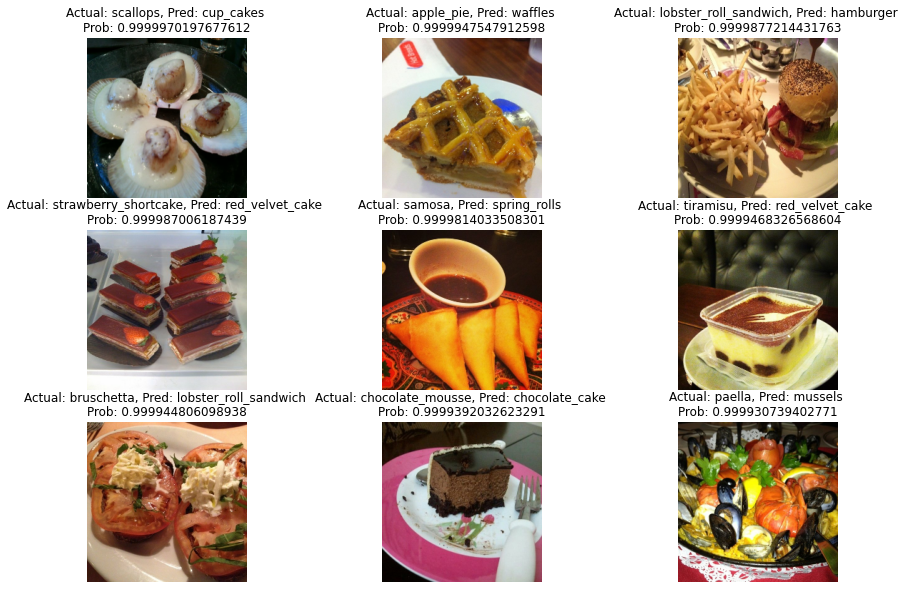

In [140]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9   # so we can visualize it in a 3 by 3 matrix!
start_index = 0  # changing this index we will be able to visualize different images from the dataset (e.g., if we put 10, it will show from 10 to 19)

plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):  # loop through the first 9 images in this case, but we could change these based on the parameters above
  plt.subplot(3, 3, i+1)
  # print(row) # returns a tuple for each pandas row iterated
  img = load_and_prep_image(row[1], scale=False)  # get the second element of the tuple returned by itertuples() for each row. The second element provides the img path                                                                                             # itertuples is to access the data in the rows in a pandas dataframe!
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row  # we are only interested in a few parameters of each row for the plot, so we just get them from unpacking the tuple
  plt.imshow(img/255.)  # so it can plot correctly, otherwise it does show error in the values as they are float in the range of integers (0-255)
  plt.title(f"Actual: {y_true_classname}, Pred: {y_pred_classname} \nProb: {pred_prob}")  # we extracted the info from the dataframe and put it in the title!
  plt.axis(False);

In [141]:
# So now we can see where the model made big errors and figure out a way to address them
# For example, adding more diverse images for really confused classes (both of them; the predicted and the ground truth), so it can learn better to differentiate them! 
# If there are mistakes (the model is correct, the label is wrong) we can relabel them!
# We can also think about merging some classes if the concepts are really similar (e.g., chocolate_mousse and chocolate_cake) and can be easily confused even for humans!
# So a very good understanding of the model performance can be extracted from visualizing the most wrong predictions and take appropriate decisions to improve it!

## Test out the big dog model on our own custom images



In [143]:
# Get custom images
!wget https://cucharonypasoatras.es/wp-content/uploads/2020/01/traditional-spanish-dish-paella-with-prawns-mussels_103153-153-500x417.jpg

# move the previous image to the folder that the next download/unzip will create!

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")



--2022-10-06 10:51:52--  https://cucharonypasoatras.es/wp-content/uploads/2020/01/traditional-spanish-dish-paella-with-prawns-mussels_103153-153-500x417.jpg
Resolving cucharonypasoatras.es (cucharonypasoatras.es)... 217.160.0.142, 2001:8d8:100f:f000::28b
Connecting to cucharonypasoatras.es (cucharonypasoatras.es)|217.160.0.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50298 (49K) [image/jpeg]
Saving to: ‘traditional-spanish-dish-paella-with-prawns-mussels_103153-153-500x417.jpg.1’

traditional-spanish 100%[===================>]  49.12K   163KB/s    in 0.3s    

2022-10-06 10:51:53 (163 KB/s) - ‘traditional-spanish-dish-paella-with-prawns-mussels_103153-153-500x417.jpg.1’ saved [50298/50298]

--2022-10-06 10:51:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.goog

In [145]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images  # we get a list of the paths to the images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/traditional-spanish-dish-paella-with-prawns-mussels_103153-153-500x417.jpg.1',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg']

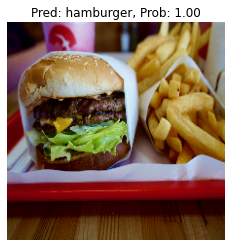

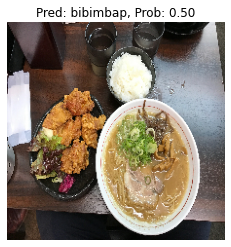

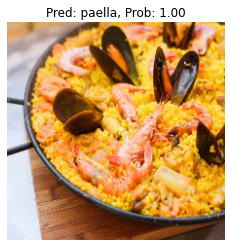

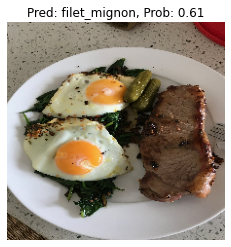

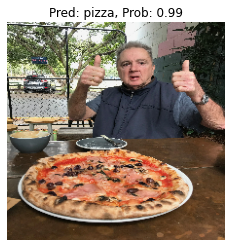

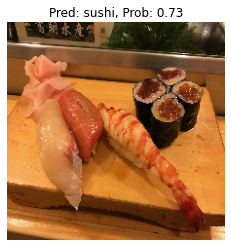

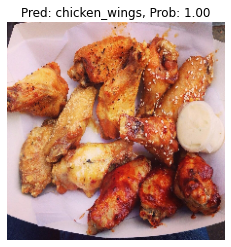

In [146]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # do not need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0))  # make prediction on image with shape [1, 224, 224, 3] as our model expects batch size dimension (same shape as our model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index of the highest prediction probability value

  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)  # so we avoid the issue of not plotting it well, we could put this inside the function
  plt.title(f"Pred: {pred_class}, Prob: {pred_prob.max():.2f}")   # we are predicting, so no ground truth is known here
  plt.axis(False);

In [147]:
# Wow, not bad at all! Most of them are correct!
# There are a few mistakes, but they are really understandable as steak and filet mignon are really similar
# And ramen and bibimbap is also kind of confusing

So this is it! This is the end of this module: we achieved the purpose of beating the original paper performance of Food101, using just 10% of the data (training images).

How would it be using 100% of the data? Let's see that in the next module.

Extra curriculum & challenges [HERE](https://github.com/mrdbourke/tensorflow-deep-learning#-06-transfer-learning-in-tensorflow-part-3-scaling-up-exercises).